In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits


In [2]:
f = fits.open('data/VIRGO_1min_0083-7404.fits')

In [3]:
f[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Written by IDL:  Thu Jun 09 12:12:01 2016      
BITPIX  =                  -64 /                                                
NAXIS   =                    1 /                                                
NAXIS1  =             10543680 /                                                
DATE    = '09/06/16'           / FITS file creation date (dd-mm-yyyy)           
EXTEND  =                    T / FILE MAY CONTAIN EXTENSIONS                    
ORIGIN  = 'PMOD/WRC'           /                                                
TELESCOP= 'SOHO'               /                                                
INSTRUME= 'PMO6V on VIRGO'     /                                                
START   = '22-02-1996'         / Start date  (dd-mm-yyyy)                       
STOPP   = '09-03-2016'         / End date  (dd-mm-yyyy)                         
SAMPLE  = 60.0000              / Sampling (sec)                                 
TIME    =      83.0002315   

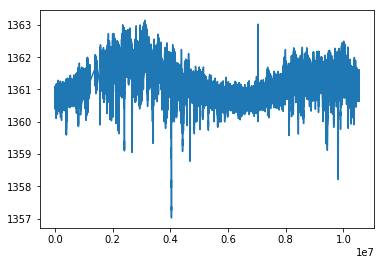

In [4]:
fluxes = f[0].data #[f[0].data != -99]
times = np.arange(len(fluxes))

interp_fluxes = np.interp(times[fluxes == -99], times[fluxes != -99], fluxes[fluxes != -99])
fluxes[fluxes == -99] = interp_fluxes

plt.plot(times, fluxes)

In [326]:
from scipy.signal import periodogram
f, Pxx_den = periodogram(fluxes, fs=1/60)#, scaling='spectrum')

In [327]:
from scipy.stats import binned_statistic

bs = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanmedian, bins=500)

# bs_std = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanstd, bins=500)

bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(0.1, 400)

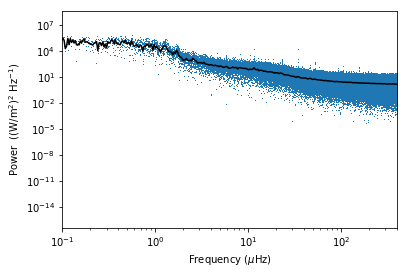

In [328]:
fig, ax = plt.subplots()
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True)
ax.loglog(1e6 * np.exp(bincenters), bs.statistic, color='k')
plt.xlabel('Frequency ($\mu$Hz)')
plt.ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')
plt.xlim([0.1, 400])
plt.ylim([1e-1, 1e6])

# plt.ylim([1e-9, 1e-3])

# plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)
# plt.axvline(10.9*365, ls='--')
#plt.xlim([0, 0.3])

In [329]:
# y = bs.statistic[1e6 * np.exp(bincenters) < 400]
# x = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters) < 400]
y = bs.statistic[1e6 * np.exp(bincenters) < 4000]
x = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters) < 4000]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


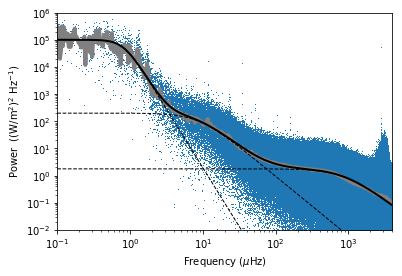

In [332]:
def individual_model(p, nu=x):
    a, b, c = p
    s = a / (1 + (b * nu)**c)
    return s

def model(p, nu=x):
    s = np.zeros_like(nu)
    for a, b, c in np.array(p).reshape((len(p)//3, 3)):
        s += a / (1 + (b * nu)**c)
    return s
    
# def minimize(p):
#     return np.sum( (y - model(p))**2 / np.sqrt(y)**2)

def minimize(p):
    return np.sum( (np.log10(y) - np.log10(model(p)))**2 )

from scipy.optimize import fmin_l_bfgs_b

initp = [1e5, 1.5, 4, 
         200, 0.08, 3, 
         2, 0, 3]
bounds = [[0.5e5, 3e5], [0.3, 2], [2, 5], 
          [100, 300], [0, 1], [2, 5], 
          [0, 5], [-1, 1], [2, 5]]

fig, ax = plt.subplots()
bestp = fmin_l_bfgs_b(minimize, initp, bounds=bounds, approx_grad=True)[0]
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.loglog(x, y, color='gray', lw=4, label='Binned')
# plt.loglog(1e6 * x, model(initp))
ax.loglog(x, model(bestp), color='k', lw=2, label='Fit')
ax.loglog(x, individual_model(bestp[:3]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp[3:6]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp[6:9]), color='k', lw=1, ls='--')

ax.set_xlabel('Frequency ($\mu$Hz)')
ax.set_ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')

ax.set_xlim([1e-1, 4000])
ax.set_ylim([1e-2, 1e6])
plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)

In [333]:
# fig, ax = plt.subplots()
# ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
# ax.loglog(x, y, color='gray', lw=4, label='Binned')
# # plt.loglog(1e6 * x, model(initp))
# ax.loglog(x, model(bestp), color='k', lw=2, label='Fit')
# ax.loglog(x, individual_model(bestp[:3]), color='k', lw=1, ls='--')
# ax.loglog(x, individual_model(bestp[3:6]), color='k', lw=1, ls='--')
# ax.loglog(x, individual_model(bestp[6:9]), color='k', lw=1, ls='--')

# ax.set_xlabel('Frequency ($\mu$Hz)')
# ax.set_ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')

# ax.set_xlim([1e3, 5e3])
# ax.set_ylim([1e-2, 1e3])
# # plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)

***

Optimization terminated successfully.
         Current function value: 75.381737
         Iterations: 8
         Function evaluations: 618


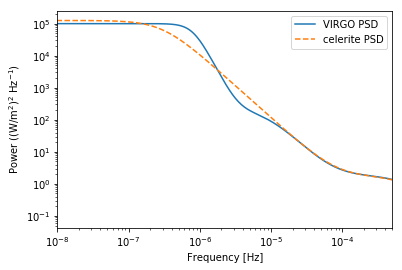

In [334]:
plt.loglog(x * 1e-6, model(bestp), label='VIRGO PSD')

kernel = (terms.SHOTerm(log_S0=10, log_omega0=-16, log_Q=1)+
         terms.SHOTerm(log_S0=10, log_omega0=-16, log_Q=1))
gp = celerite.GP(kernel)

from scipy.optimize import fmin_powell, fmin_l_bfgs_b

def minimize(p):
    gp.kernel.set_parameter_vector(p)
    return np.sum( ( np.log(model(bestp)) - np.log(gp.kernel.get_psd(2 * np.pi * x * 1e-6)) )**2 ) 

fit1 = fmin_powell(minimize, [12, -16, 1, 5, -10, 1])#, approx_grad=True)

gp.kernel.set_parameter_vector(fit1)

plt.loglog(x*1e-6, gp.kernel.get_psd(2 * np.pi * x * 1e-6), ls='--', label='celerite PSD')
plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power ((W/m$^2$)$^2$ Hz$^{-1}$)')
plt.xlim([1e-8, 5e-4])
plt.savefig('paper_plots/psd_fit.png', bbox_inches='tight', dpi=200)
# for term in gp.kernel.terms: 
#     plt.loglog(x*1e-6, term.get_psd(x*1e-6), ls='--', color='DodgerBlue')

Text(0,0.5,'Power ((W/m$^2$)$^2$ Hz$^{-1}$)')

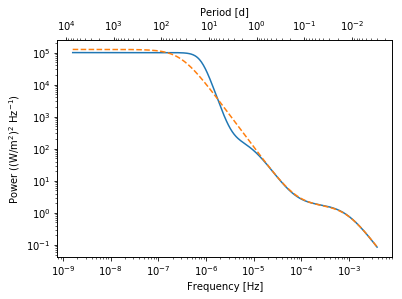

In [335]:
fig, ax = plt.subplots()
ax.loglog(x * 1e-6, model(bestp), label='VIRGO PSD')
ax.loglog(x*1e-6, gp.kernel.get_psd(2 * np.pi * x * 1e-6), ls='--', label='celerite PSD')

ax2 = ax.twiny()

T_f = lambda T_c: (1/T_c) / 60 / 60 / 24
# get left axis limits
xmin, xmax = ax.get_xlim()
# apply function and set transformed values to right axis limits
ax2.set_xlim((T_f(xmin),T_f(xmax)))
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
ax2.loglog([],[])
ax2.set_xlabel('Period [d]')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power ((W/m$^2$)$^2$ Hz$^{-1}$)')

In [336]:
fit1

array([ 11.96723472, -14.17064747,   0.9945821 ,   0.74125768,
        -6.14528619,   0.97855108])

In [337]:
sdo_times = np.arange(0, times[-1], 10)
gp.compute(sdo_times)
ytest = gp.sample()

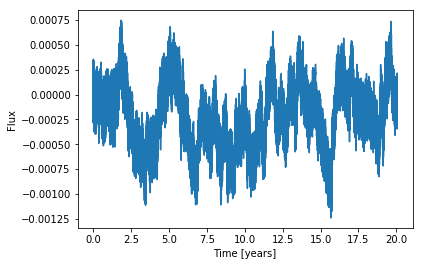

In [344]:
plt.plot(sdo_times/60/24/365, ytest/fluxes.mean())
np.save('inverted_psd.npy', np.vstack([sdo_times/60/24, ytest/fluxes.mean()]).T)
plt.xlabel('Time [years]')
plt.ylabel('Flux')
plt.savefig('paper_plots/psd_sample.png', bbox_inches='tight', dpi=250)

(0, 1)

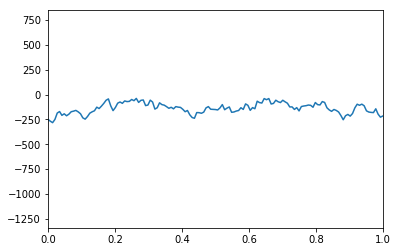

In [340]:
plt.plot(sdo_times/60/24, 1e6 * ytest/fluxes.mean())
plt.xlim([0, 1])

In [341]:
ftest, Ptest = periodogram(ytest)

(1e-06, 10000000000.0)

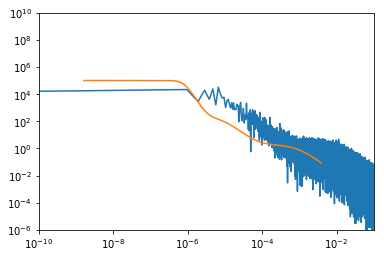

In [342]:
plt.loglog(ftest, Ptest)
plt.loglog(x * 1e-6, model(bestp), label='VIRGO PSD')

plt.xlim([1e-10, 1e-1])
plt.ylim([1e-6, 1e10])

Text(0,0.5,'Relative Flux')

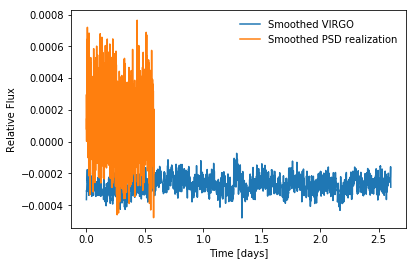

In [297]:
plt.plot(np.arange(5000)*45/60/60/24, fluxes[1000:6000] / fluxes.mean() - 1, label='Smoothed VIRGO')
plt.plot(np.arange(5000)*10/60/60/24, ytest[1000:6000] / fluxes.mean(), label='Smoothed PSD realization')
plt.legend().get_frame().set_visible(False)
plt.xlabel('Time [days]')
plt.ylabel('Relative Flux')

In [286]:
times[:30]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

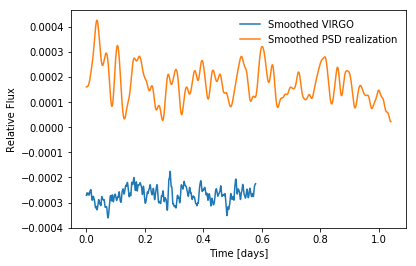

In [294]:
from scipy.ndimage import gaussian_filter1d
# from scipy.signal import medfilt as gaussian_filter1d

plt.plot(np.arange(5000)*10/60/60/24, gaussian_filter1d(fluxes[1000:6000] / fluxes.mean() - 1, 13), label='Smoothed VIRGO')
plt.plot(np.arange(2000)*45/60/60/24, gaussian_filter1d(ytest[1000:3000] / fluxes.mean(), 13), label='Smoothed PSD realization')
plt.legend()
plt.legend().get_frame().set_visible(False)
plt.xlabel('Time [days]')
plt.ylabel('Relative Flux')
plt.savefig('paper_plots/psd_comparison.png', bbox_inches='tight', dpi=250)